%%

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import shutil

In [2]:
from tensorflow.python.keras.regularizers import L2
from WGAN_GP import WGAN_GP

general functions

In [3]:
def load_data(batch_size):
    (train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = train_images.reshape(train_images.shape + (1,)).astype('float32') / 127.5 - 1
    ds = tf.data.Dataset.from_tensor_slices(train_images)
    ds = ds.shuffle(len(ds)).batch(batch_size, drop_remainder=True)
    return ds

In [4]:
def bn_relu(x, useRelu=True):
    fx = layers.BatchNormalization()(x)
    if useRelu:
        fx = layers.LeakyReLU(0.2)(fx)
    return fx

In [5]:
def conv(x, filterNumb, kernel_size, strides=1, use_bias=True):
    fx = layers.Conv2D(filterNumb, kernel_size, strides, padding='same', 
                    use_bias=use_bias, kernel_regularizer=L2(0.01))(x)
    return fx

In [6]:
def residual_block(x, filterNumb, isPooling=False):
    strides = 1
    shortcut = x
    bn_x = bn_relu(x)
    if isPooling:
        strides = (2,2)
        shortcut = conv(bn_x, filterNumb, kernel_size=1, strides=strides)
    fx = conv(bn_x, filterNumb, kernel_size=3, strides=strides)
    fx = bn_relu(fx)
    fx = conv(fx, filterNumb, kernel_size=3)
    out = layers.Add()([shortcut, fx]) # skip
    return out

In [7]:
def conv_transpose(model, kernels, strides, activation=None):
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2DTranspose(kernels, (3, 3), strides=strides, padding='same', use_bias=False))   

In [8]:
def generate_image(gan_model, seed=None, isShow=True, isSaveFile=False):
    grid_size = (3,3)
    w, h = grid_size
    img_count = w * h
    if seed is None:
        seed = tf.random.normal(shape=(9, gan_model.seed_size))
    fake_img_batch = gan_model.generator(test_seed, training=False)
    fig = plt.figure(figsize=grid_size, dpi=100)
    fig.set_figheight(5)
    fig.set_figwidth(5)
    for i in range(img_count):
        plt.subplot(w, h, i+1)
        plt.imshow(fake_img_batch[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    if isShow: 
        plt.show()
    if isSaveFile:
        if not os.path.exists('./Results'):
            os.makedirs('./Results')
        plt.savefig('./Results/{:06d}.png'.format(gan_model.dis_opt.iterations.numpy()))
        
# models
def create_generator(seed_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(seed_size,)))
    model.add(layers.Reshape((4, 4, 256)))
    assert model.output_shape == (None, 4, 4, 256)
    conv_transpose(model, 128, (2,2))
    assert model.output_shape == (None, 8, 8, 128)
    conv_transpose(model, 64, (2,2))
    assert model.output_shape == (None, 16, 16, 64)
    conv_transpose(model, 1, (2,2))
    assert model.output_shape == (None, 32, 32, 1)
    
    model.add(layers.Cropping2D((2,2)))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

In [9]:
def create_discriminator():
    inputs = layers.Input(shape=(28,28,1)) # 28*28
    hx = layers.ZeroPadding2D((2,2))(inputs) # 32*32
    hx = conv(hx, 32, kernel_size=5, strides=2)
    hx = layers.LeakyReLU(0.2)(hx)
    hx = layers.Dropout(0.3)(hx)
    hx = conv(hx, 64, kernel_size=5, strides=2)
    hx = layers.LeakyReLU(0.2)(hx)
    hx = layers.Dropout(0.3)(hx)
    hx = conv(hx, 128, kernel_size=5, strides=2)
    hx = layers.LeakyReLU(0.2)(hx)
    hx = layers.Dropout(0.2)(hx)
    hx = layers.Flatten()(hx)
    hx = layers.Dense(512)(hx)
    hx = layers.LeakyReLU(0.2)(hx)
    hx = layers.Dropout(0.2)(hx)
    outputs = layers.Dense(1)(hx)
    model = tf.keras.Model(inputs, outputs)
    return model

In [10]:
def create_WGAN_GP(seed_size, gen_lr, dis_lr, dis_extra_steps):
    generator = create_generator(seed_size)
    discriminator = create_discriminator()
    gen_opt = tf.keras.optimizers.RMSprop(learning_rate=gen_lr)
    dis_opt = tf.keras.optimizers.RMSprop(learning_rate=dis_lr)
    gen_loss_fn = lambda fake_pred: -tf.reduce_mean(fake_pred)
    dis_loss_fn = lambda real_pred, fake_pred: tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred)
    gan_model = WGAN_GP(discriminator, generator, seed_size, dis_extra_steps=dis_extra_steps)
    gan_model.compile(gen_opt, dis_opt, gen_loss_fn, dis_loss_fn)
    return gan_model

In [11]:
epochs = 40
seed_size = 100
batch_size = 256
gen_lr = 0.0003
dis_lr = 0.0003

In [12]:
test_seed = tf.random.normal(shape=(9, seed_size))
ds = load_data(batch_size)
gan_model = create_WGAN_GP(seed_size, gen_lr, dis_lr, dis_extra_steps=2)
    

%% ======= training =================

234/234 [==============================] - 17s 71ms/step - dis_loss: -1.1909 - gen_loss: -7.4198
Epoch 1/40
234/234 [==============================] - 18s 75ms/step - dis_loss: -1.0848 - gen_loss: -6.5158
Epoch 2/40
234/234 [==============================] - 18s 75ms/step - dis_loss: -1.0019 - gen_loss: -4.9774
Epoch 3/40
 91/234 [==========>...................] - ETA: 10s - dis_loss: -1.0169 - gen_loss: -4.6257

KeyboardInterrupt: 

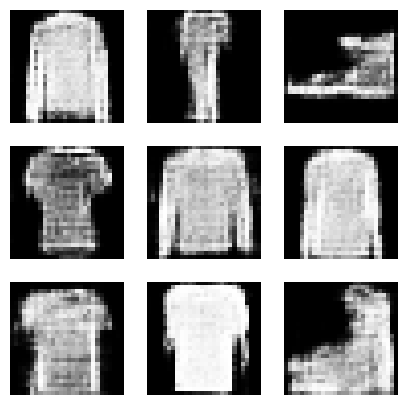

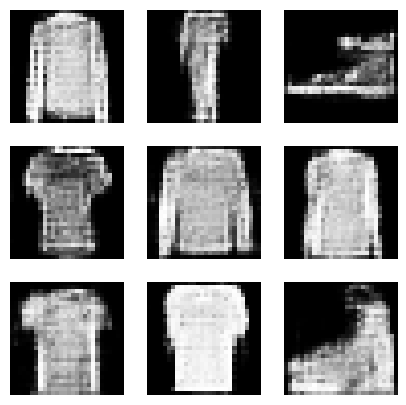

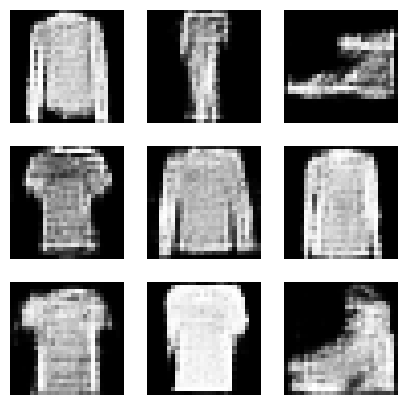

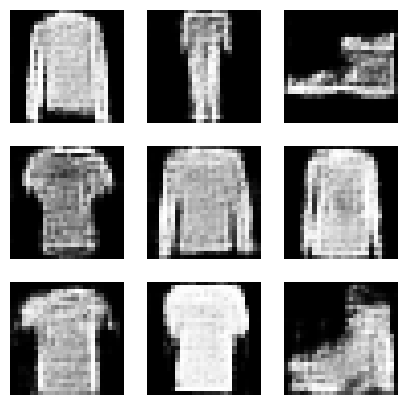

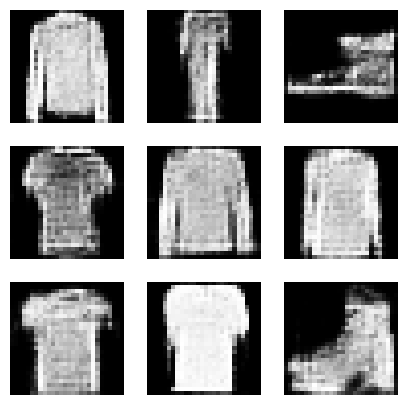

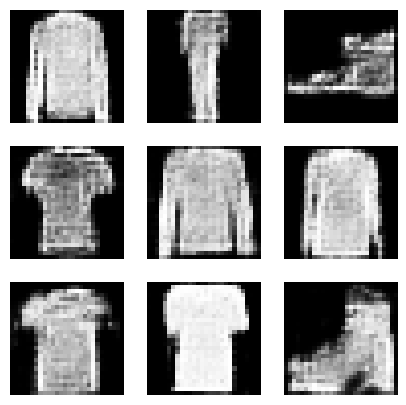

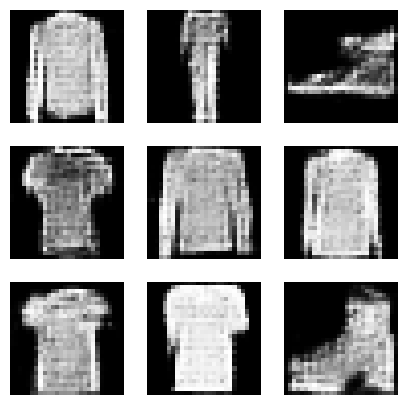

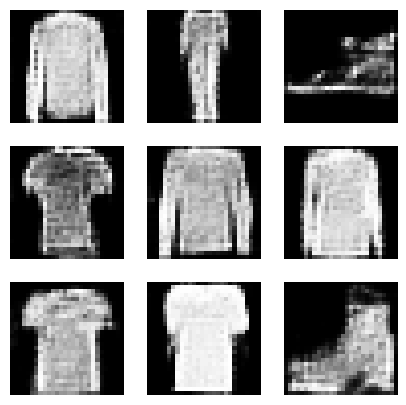

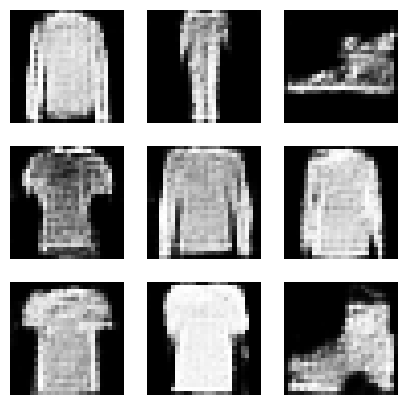

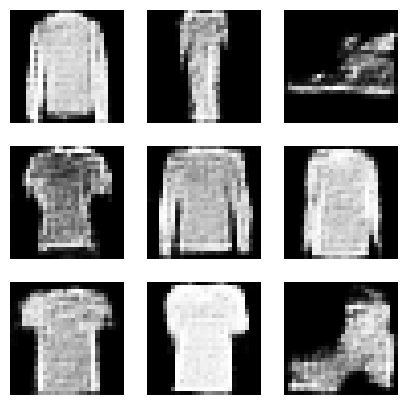

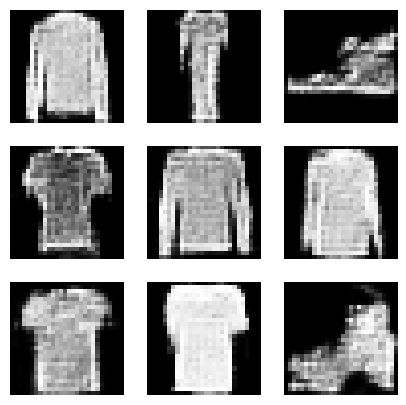

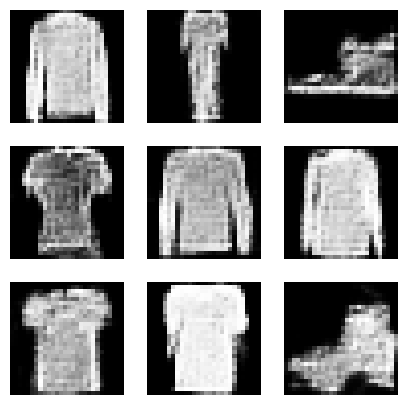

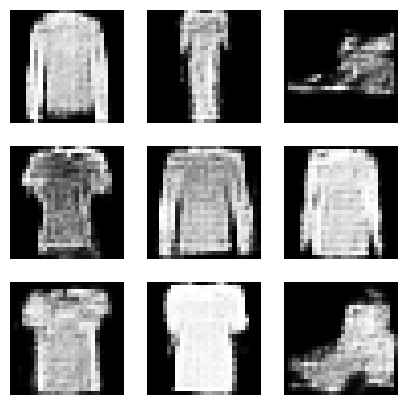

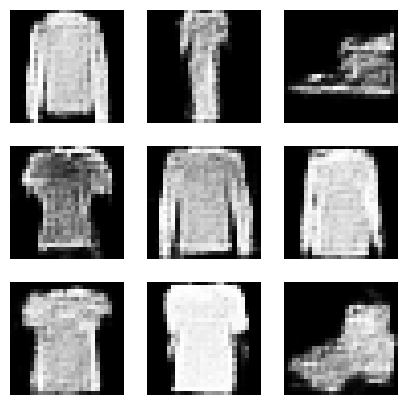

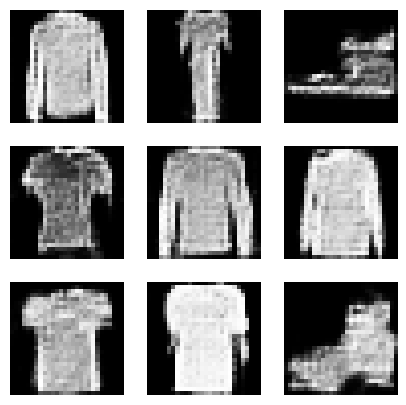

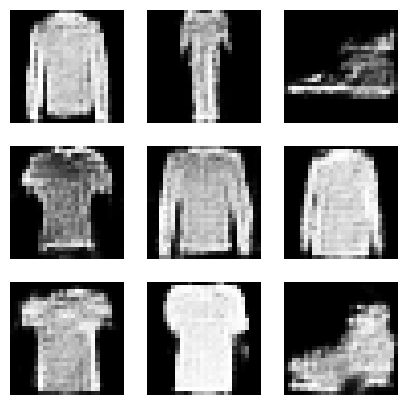

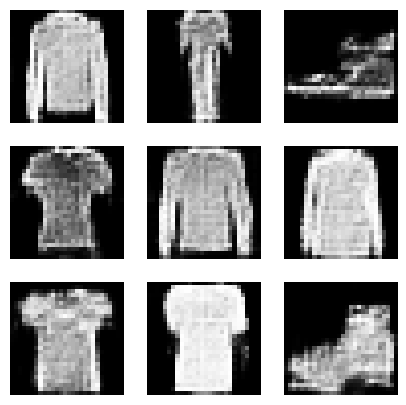

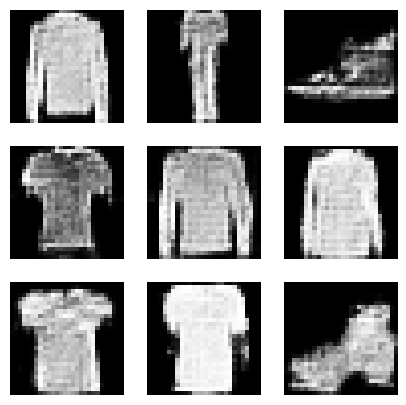

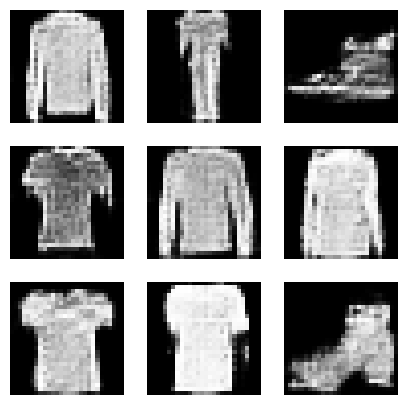

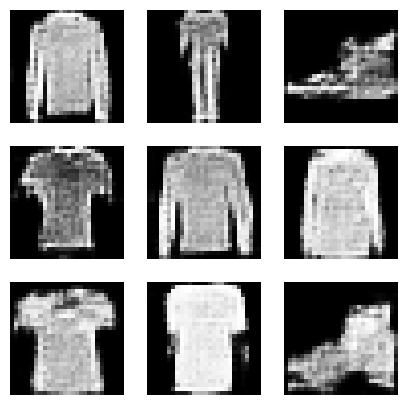

In [19]:
shutil.rmtree('./tb_logs', ignore_errors=True)
shutil.rmtree('./Results', ignore_errors=True)
class GANMonitor(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        if batch % 30 == 0:
            generate_image(self.model, seed=test_seed, isShow=False, isSaveFile=True)
        
mon_cb = GANMonitor()
save_cb = tf.keras.callbacks.ModelCheckpoint( './Checkpoints/', verbose=1)
board_cb = tf.keras.callbacks.TensorBoard( log_dir='./tb_logs/', write_images=True, update_freq='epoch') 
gan_model.fit(ds, epochs=epochs, shuffle=True, callbacks=[mon_cb])

%% ======= testing =================

In [ ]:
import glob
import imageio

In [ ]:
def create_gif():
    with imageio.get_writer('./Results/result.gif', mode='I') as writer:
        filenames = glob.glob('./Results/*.png')
        filenames = sorted(filenames)
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)
create_gif()